In [4]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

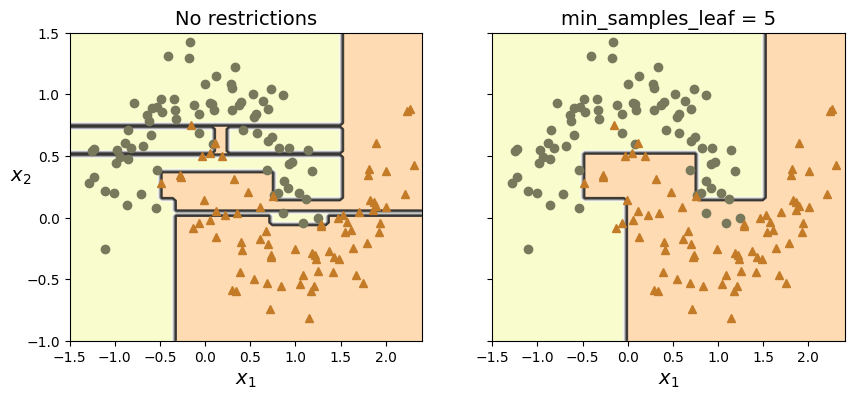

In [28]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
plt.show()

In [29]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_score_1 = tree_clf1.score(X_moons_test, y_moons_test)

tree_score_2 = tree_clf2.score(X_moons_test, y_moons_test)

print("score of unlimited tree: {}, score of tree with 5 minimum samples per leaf {}".format(tree_score_1, tree_score_2))

score of unlimited tree: 0.898, score of tree with 5 minimum samples per leaf 0.92


In [31]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

def print_metrics(predicted: np.ndarray, labels: np.ndarray):

    recall = recall_score(predicted, labels)
    precision = precision_score(predicted, labels)
    accuracy = accuracy_score(predicted, labels)

    print("Tree 1: Accuracy: {}, Precision: {}, Recall: {}".format(
                        accuracy, precision, recall ))

print_metrics(tree_clf1.predict(X_moons_test), y_moons_test)
print_metrics(tree_clf2.predict(X_moons_test), y_moons_test)


Tree 1: Accuracy: 0.898, Precision: 0.932, Recall: 0.8726591760299626
Tree 1: Accuracy: 0.92, Precision: 0.944, Recall: 0.9007633587786259


A trained `DecisionTreeClassifier` has a `tree_` attribute that stores the tree's structure:

In [74]:
tree = tree_clf.tree_
tree

You can get the total number of nodes in the tree:

In [75]:
tree.node_count

5

And other self-explanatory attributes are available:

In [76]:
tree.max_depth

2

In [77]:
tree.max_n_classes

3

In [78]:
tree.n_features

2

In [79]:
tree.n_outputs

1

In [80]:
tree.n_leaves

3

All the information about the nodes is stored in NumPy arrays. For example, the impurity of each node:

In [81]:
tree.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

The root node is at index 0. The left and right children nodes of node _i_ are `tree.children_left[i]` and `tree.children_right[i]`. For example, the children of the root node are:

In [82]:
tree.children_left[0], tree.children_right[0]

(1, 2)

When the left and right nodes are equal, it means this is a leaf node (and the children node ids are arbitrary):

In [94]:
tree.children_left[3], tree.children_right[3]

(-1, -1)

So you can get the leaf node ids like this:

In [95]:
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

Non-leaf nodes are called _split nodes_. The feature they split is available via the `feature` array. Values for leaf nodes should be ignored:

In [96]:
tree.feature

array([ 0, -2,  1, -2, -2], dtype=int64)

And the corresponding thresholds are:

In [97]:
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

And the number of instances per class that reached each node is available too:

In [98]:
tree.value

array([[[50., 50., 50.]],

       [[50.,  0.,  0.]],

       [[ 0., 50., 50.]],

       [[ 0., 49.,  5.]],

       [[ 0.,  1., 45.]]])

In [99]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [100]:
np.all(tree.value.sum(axis=(1, 2)) == tree.n_node_samples)

True

Here's how you can compute the depth of each node:

In [101]:
def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth

depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

Here's how to get the thresholds of all split nodes at depth 1:

In [102]:
tree_clf.tree_.feature[(depth == 1) & (~is_leaf)]

array([1], dtype=int64)

In [103]:
tree_clf.tree_.threshold[(depth == 1) & (~is_leaf)]

array([1.75])